# Start you dataset visualization here  
### modify the analysis_file to the string where the dataframe file (.csv) produced by SymDesign.py analysis lives and the filter_file variable to the provided symdesign/data/filter_and_sort_df.csv

In [7]:
!pwd

/home/kylemeador/symdesign/jupyter_notebooks


In [19]:
analysis_file = '/home/kylemeador/designs/T33/AllDesignPoseMetrics_Total.csv' # YOUR ANALYSIS FILE HERE
filter_file = '/home/kylemeador/symdesign/data/filter_and_sort_df.csv'

Import the required packages

In [9]:
import os
import math
import operator
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Magic methods ensure any changes to imported files stay current in the notebook

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
mean = 'mean'
std = 'std'
idx = pd.IndexSlice

In [12]:
def columns_to_new_column(df, column_dict, mode='add'):
    """Find new column values by taking an operation of one column on another

    Args:
        df (pandas.DataFrame): Dataframe where the columns are located
        column_dict (dict): A dictionary with keys as new column names, values as tuple of columns.
            Where value[0] mode(operation) value[1] = key
    Keyword Args:
        mode='add' (str) = What operator to use?
            Viable options are included in module operator, but could be 'sub', 'mul', 'truediv', etc.
    Returns:
        df (pandas.DataFrame): Dataframe with new column values
    """
    for column in column_dict:
        try:
            df[column] = operator.attrgetter(mode)(operator)(df[column_dict[column][0]], df[column_dict[column][1]])
        except KeyError:
            pass

    return df

In [13]:
# need {column: {'direction': 'max', 'val': 0.5, 'idx': []}, ...}
def df_filter_index_by_value(df, **kwargs):
    """Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
    on whether the column should be sorted max/min
    Args:
        df (pandas.DataFrame): DataFrame to filter indices on
    Keyword Args:
        kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
    """
    indices_l = []
    for _index in kwargs:
        if kwargs[_index]['direction'] == 'max':
            kwargs[_index]['idx'] = df[df[_index] >= kwargs[_index]['value']].index.to_list()
        if kwargs[_index]['direction'] == 'min':
            kwargs[_index]['idx'] = df[df[_index] <= kwargs[_index]['value']].index.to_list()
    
    return kwargs

In [14]:
def index_intersection(filtered_indices):
    """Take the intersection of provided indices in key, value pairs
    
    Args:
        filtered_indices (dict): {metric: indices, ...}
    Returns:
        (list): All indices in each provided metric
    """
    final_indices = set()
    # find all set union
    for metric in filtered_indices:
        final_indices = set(final_indices) | set(filtered_indices[metric])
        
    # find all set intersection
    for metric in filtered_indices:
        final_indices = set(final_indices) & set(filtered_indices[metric])
    return list(final_indices)

In [49]:
def return_df_feature_descriptors(df):
    """From a dataframe, return only the numeric features (columns) and their statistcial descriptions
    
    Returns:
        (pandas.DataFrame)
    """
    numerical_df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1)
    measures = {'mean': numerical_df.mean(), 
                'std': numerical_df.std(),
                'min': numerical_df.min(),
                'max': numerical_df.max()}
    descriptor_df = pd.DataFrame(measures)
    descriptor_df['range'] = descriptor_df['max'] - descriptor_df['min']
    return pd.concat([descriptor_df], keys=['descriptors'], axis=1)

Importing filter_key

In [17]:
filter_key_df = pd.read_csv(filter_file, index_col=0)
display(filter_key_df)

,buns_per_ang,buns_heavy_total,buns_hpol_total,buns_total,component_1_number_of_residues,component_1_symmetry,component_2_number_of_residues,component_2_symmetry,contact_count,cst_weight,fsp_energy,fsp_total_stability,full_stability,int_area_hydrophobic,int_area_polar,int_area_res_summary_hydrophobic_1_unbound,int_area_res_summary_hydrophobic_2_unbound,int_area_res_summary_polar_1_unbound,int_area_res_summary_polar_2_unbound,int_area_res_summary_total_1_unbound,int_area_res_summary_total_2_unbound,int_area_total,int_composition_similarity,int_connectivity_1,int_connectivity_2,int_energy_context_1_unbound,int_energy_context_2_unbound,int_energy_context_complex,int_energy_context_delta,int_energy_context_unbound,int_energy_res_summary_complex,int_energy_res_summary_delta,int_energy_res_summary_unbound,int_energy_res_summary_1_unbound,int_energy_res_summary_2\n_unbound,int_separation,interaction_energy_complex,multiple_fragment_ratio,nanohedra_score,nanohedra_score_central,nanohedra_score_per_res,number_hbonds,number_fragment_residues_central,number_fragment_residues_total,observed_design,observed_evolution,observed_fragment,percent_int_area_hydrophobic,percent_int_area_polar,percent_core,percent_fragment,percent_fragment_coil,percent_fragment_helix,percent_fragment_strand,percent_residues_fragment_total,percent_residues_fragment_center,percent_rim,percent_support,protocol_energy_distance_sum,protocol_seq_distance_sum,protocol_similarity_sum,ref,rmsd,shape_complementarity,solvation_energy,average_fragment_z_score,interface_b_factor_per_res,observations,total_interface_residues,unique_fragments,core,divergence_design_per_res,divergence_evolution_per_res,divergence_fragment_per_res,divergence_interface_per_res,rim,support,Unnamed: 78
direction,min,min,min,min,max,min,min,min,max,min,max,min,min,min,max,min,min,max,max,max,max,max,max,max,max,max,max,min,min,min,min,min,min,min,min,min,min,max,max,max,max,max,max,max,max,max,max,min,max,max,max,max,max,max,max,max,min,max,min,min,max,max,min,max,min,min,max,max,max,max,max,min,min,min,min,max,max,NaN
function,normalize,rank,rank,rank,rank,equals,rank,equals,rank,normalize,normalize,normalize,normalize,rank,rank,rank,rank,rank,rank,rank,rank,rank,rank,normalize,normalize,normalize,normalize,rank,rank,rank,rank,rank,rank,rank,rank,normalize,rank,rank,rank,rank,rank,rank,rank,rank,rank,rank,rank,normalize,normalize,normalize,normalize,normalize,normalize,normalize,normalize,normalize,normalize,normalize,rank,rank,rank,rank,normalize,normalize,rank\n,normalize,rank,rank,rank,rank,rank,rank,rank,rank,rank,rank,rank,NaN
filter,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE\n,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,NaN


In [172]:
df = pd.read_csv(analysis_file, index_col=0, header=[0,1,2])

In [173]:
df = df.rename_axis(columns=['protocol', 'measure', 'metric'])
print('Starting size')
display(df.shape)
# outliers = (df.loc[:, idx['pose', mean, 'int_energy_res_summary_unbound']] >= 10)  # .any(axis=1) if using multiple columns
# df = df.loc[~outliers, :]  # .any(axis=0)
# print('Removing energy outliers')
# display(df.shape)
df.dropna(inplace=True)
print('Removing missing values')
display(df.shape)

Starting size


(493874, 27)

Removing missing values


(493874, 27)

## Visualize data descriptors (mean, standard deviation, min, max, range) for the dataframe

In [174]:
df.rename(columns={'unique_fragments': 'number_fragments', 'nanohedra_score_per_res': 'nanohedra_score_center_per_res_center',
                   'number_fragment_residues_central': 'number_fragment_residues_center',
                   'nanohedra_score_central': 'nanohedra_score_center'}, inplace=True)

In [175]:
df

protocol                                                           pose  \
measure                                                            dock   
metric                               component_1_c_terminal_orientation   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191                                 -1   
...                                                                 ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203                                 -1   

protocol                                                     \
measure                                                       
metric                               component_1_max_radius   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210              76.821750   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211              75.572927   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213              75.307815   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215              75.261429   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191              76.159011   
...                                                     ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140              73.604927   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145              73.967036   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149              73.773559   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151              73.699158   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203              75.331008   

protocol                                                                 \
measure                                                                   
metric                               component_1_n_terminal_orientation   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191                                  1   
...                                                                 ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203                                  1   

protocol                                               \
measure                                                 
metric                               component_1_name   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191           4MI2_1   
...                                               ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203           4MI2_1   

protocol                                                             \
measure                                                               
metric                               component_1_number_of_residues   
4mi

In [176]:
df[('pose', 'dock', 'nanohedra_score_per_res')] = df[('pose', 'dock', 'nanohedra_score')] / df [('pose', 'dock', 'number_fragment_residues_total')]
df[('pose', 'dock', 'non_fragment_residues')] = df[('pose', 'dock', 'total_interface_residues')] - df [('pose', 'dock', 'number_fragment_residues_center')]
# display(df)

protocol                                                           pose  \
measure                                                            dock   
metric                               component_1_c_terminal_orientation   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191                                 -1   
...                                                                 ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151                                 -1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203                                 -1   

protocol                                                     \
measure                                                       
metric                               component_1_max_radius   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210              76.821750   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211              75.572927   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213              75.307815   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215              75.261429   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191              76.159011   
...                                                     ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140              73.604927   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145              73.967036   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149              73.773559   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151              73.699158   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203              75.331008   

protocol                                                                 \
measure                                                                   
metric                               component_1_n_terminal_orientation   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191                                  1   
...                                                                 ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151                                  1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203                                  1   

protocol                                               \
measure                                                 
metric                               component_1_name   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_210           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_211           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_213           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_215           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_23-tx_191           4MI2_1   
...                                               ...   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_140           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_145           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_149           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_151           4MI2_1   
4mi2_4m1a-DEGEN_1_1-ROT_34_21-tx_203           4MI2_1   

protocol                                                             \
measure                                                               
metric                               component_1_number_of_residues   
4mi

In [177]:
df_descriptors = return_df_feature_descriptors(df)

In [178]:
df_descriptors

descriptors             \
                                                              mean        std   
protocol measure metric                                                         
pose     dock    component_1_c_terminal_orientation       0.294824   0.955552   
                 component_1_max_radius                  75.244177  17.118494   
                 component_1_n_terminal_orientation       0.563127   0.826371   
                 component_1_number_of_residues         183.759556  71.099310   
                 component_2_c_terminal_orientation       0.191960   0.981404   
                 component_2_max_radius                  75.456900  18.081794   
                 component_2_n_terminal_orientation       0.258924   0.965899   
                 component_2_number_of_residues         197.435763  77.341921   
                 design_dimension                         0.000000   0.000000   
                 interface_b_factor_per_res              20.000000   0.000000   
                 multiple_fragment_ratio                  3.524184   1.063585   
                 nanohedra_score                         21.694203   5.098653   
                 nanohedra_score_center                   8.460259   3.026140   
                 nanohedra_score_center_per_res_center    0.932243   0.139427   
                 number_fragment_residues_center          9.155696   3.148872   
                 number_fragment_residues_total          24.922063   7.210454   
                 percent_fragment_coil                    0.005649   0.023693   
                 percent_fragment_helix                   0.992493   0.027880   
                 percent_fragment_strand                  0.001858   0.014235   
                 percent_residues_fragment_center         0.337102   0.151532   
                 percent_residues_fragment_total          0.929882   0.418000   
                 total_interface_residues                31.314078  13.971467   
                 number_fragments                        16.340611   7.869852   
                 nanohedra_score_per_res                  0.891676   0.133030   
                 non_fragment_residues                   22.158383  13.100828   

                                                                               \
                                                              min         max   
protocol measure metric                                                         
pose     dock    component_1_c_terminal_orientation     -1.000000    1.000000   
                 component_1_max_radius                 39.685598  200.481232   
                 component_1_n_terminal_orientation     -1.000000    1.000000   
                 component_1_number_of_residues         33.000000  366.000000   
                 component_2_c_terminal_orientation     -1.000000    1.000000   
                 component_2_max_radius                 39.780388  206.341153   
                 component_2_n_terminal_orientation     -1.000000    1.000000   
                 component_2_number_of_residues         33.000000  384.000000   
                 design_dimension                        0.000000    0.000000   
                 interface_b_factor_per_res             20.000000   20.000000   
                 multiple_fragment_ratio                 1.000000    8.666667   
                 nanohedra_score                         9.408189   61.815956   
                 nanohedra_score_center                  2.173510   33.925110   
                 nanohedra_score_center_per_res_center   0.433220    1.811962   
                 number_fragment_residues_center         3.000000   34.000000   
                 number_fragment_residues_total         11.000000   83.000000   
                 percent_fragment_coil                   0.000000    0.857143   
                 percent_fragment_helix                  0.142857    1.000000   
                 percent_fragment_strand                 0.000000    0.500000   
    

In [179]:
unique_protocols = df.columns.get_level_values('protocol').unique().to_list()
unique_protocols.remove('pose')

In [180]:
pose_df = df.loc[:, idx['pose',[mean, 'dock', 'seq_design'], :]]
pose_df = pose_df.droplevel(1, axis=1)  # .droplevel(0, axis=1)

In [188]:
# display(pose_df)
pose_df.loc['2pd2_4n72-DEGEN_1_1-ROT_20_37-tx_131', :]

protocol  metric                               
pose      component_1_c_terminal_orientation               1
          component_1_max_radius                   51.669205
          component_1_n_terminal_orientation              -1
          component_1_name                            2PD2_1
          component_1_number_of_residues                 108
          component_1_symmetry                            C3
          component_2_c_terminal_orientation               1
          component_2_max_radius                   80.760612
          component_2_n_terminal_orientation              -1
          component_2_name                            4N72_1
          component_2_number_of_residues                 245
          component_2_symmetry                            C3
          design_dimension                                 0
          interface_b_factor_per_res                    20.0
          multiple_fragment_ratio                       5.75
          nanohedra_score            

## Filter on metrics in the dataframe 
These metrics were pulled from Janin et al. 2008 as the set of crystal interface identifiers.  
You can define other identifiers in similar {key: value} pairs

In [208]:
crystal_means = {'int_area_total': 570, 'shape_complementarity': 0.63, 'number_hbonds': 5}
# Each of these produces the highest 10% scoring for the individual metrics
top_10_percent = {'total_interface_residues': 50,  # 35-176002 35-70 in Bale work with 12 A distance...
               'nanohedra_score_center': 12.5,  # 13-38904, 15-15018
               'multiple_fragment_ratio': 5,  # 49410 , lower (3.52) missed beneficial additive secondary structure
               'number_fragments': 28}  # 25-74423, 20-148471
other_means = {'total_interface_residues': 35,  # -176002 35-70 in Bale work with 12 A distance...
               'nanohedra_score_center': 15,  # -15018
               'multiple_fragment_ratio': 5,  # 49410 , lower (3.52) missed beneficial additive secondary structure
               'number_fragments': 20}  #-148471
homo_bio_means = {'total_interface_residues': 81,  # 2099
                  'nanohedra_score_center': 14.28,  # 21310
                  'multiple_fragment_ratio': 2.41,  # 413620
                  'number_fragments': 21.22}  # 114185
sheet_means = {'total_interface_residues': 35,
#                'nanohedra_score_central': 15,
               'percent_fragment_strand': 0.2}  # this gives 222 designs

Modify 'design_filters' variable to set your filters of choice

In [225]:
design_filters = other_means
# design_selection_file = '210331_T33DockingMetricsPose.ids'

# design_filters = homo_bio_means

# design_filters = top_10_percent
design_selection_file = '210331_T33Top10percentDockingPoseMetric.ids'

In [226]:
print('Starting designs = %d' % len(pose_df))
filtered_indices = {}
for metric in design_filters:
    filtered_indices[metric] = set(pose_df[pose_df.droplevel(0, axis=1)[metric] >= design_filters[metric]].index.to_list())
    print('Number of designs passing %s = %d' % (metric, len(filtered_indices[metric])))

Starting designs = 493874
Number of designs passing total_interface_residues = 176002
Number of designs passing nanohedra_score_center = 15018
Number of designs passing multiple_fragment_ratio = 49410
Number of designs passing number_fragments = 148471


In [227]:
final_indices = index_intersection(filtered_indices)
print('Final number of designs passing all metrics is %d' % len(final_indices))

Final number of designs passing all metrics is 1431


In [204]:
filtered_df = df.loc[final_indices, :].droplevel(0, axis=1).droplevel(0, axis=1).sort_values('nanohedra_score_center')

In [205]:
display(filtered_df)

metric,component_1_c_terminal_orientation,component_1_max_radius,component_1_n_terminal_orientation,component_1_name,component_1_number_of_residues,component_1_symmetry,component_2_c_terminal_orientation,component_2_max_radius,component_2_n_terminal_orientation,component_2_name,component_2_number_of_residues,component_2_symmetry,design_dimension,interface_b_factor_per_res,multiple_fragment_ratio,nanohedra_score,nanohedra_score_center,nanohedra_score_center_per_res_center,number_fragment_residues_center,number_fragment_residues_total,percent_fragment_coil,percent_fragment_helix,percent_fragment_strand,percent_residues_fragment_center,percent_residues_fragment_total,total_interface_residues,number_fragments,nanohedra_score_per_res,non_fragment_residues
3tcr_4glf-DEGEN_1_1-ROT_40_12-tx_192,1,83.157840,-1,3TCR_1,158,C3,-1,75.336960,1,4GLJ_1,287,C3,0,20.0,6.166667,26.898109,12.502078,1.041840,12,26,0.0,1.0,0.0,0.235294,0.509804,51,37,1.034543,39
3hrx_3qv0-DEGEN_1_1-ROT_22_8-tx_168,-1,80.656150,1,6SLB_1,254,C3,1,78.062389,1,3QV0_1,179,C3,0,20.0,5.000000,33.384214,12.512304,1.042692,12,32,0.0,1.0,0.0,0.210526,0.561404,57,30,1.043257,45
3tcr_2i9d-DEGEN_1_1-ROT_26_21-tx_77,1,53.527106,1,3TCR_1,158,C3,-1,79.389973,-1,2I9D_1,186,C3,0,20.0,5.272727,24.642473,12.524364,1.138579,11,24,0.0,1.0,0.0,0.169231,0.369231,65,29,1.026770,54
3q98_3l7q-DEGEN_1_1-ROT_1_4-tx_65,1,96.861910,1,3Q98_1,366,C3,1,53.200204,1,3L7Q_1,124,C3,0,20.0,5.000000,33.385848,12.533732,0.895267,14,38,0.0,1.0,0.0,0.280000,0.760000,50,35,0.878575,36
3l7q_2i9d-DEGEN_1_1-ROT_37_35-tx_37,-1,58.471713,-1,3L7Q_1,124,C3,1,78.282484,-1,2I9D_1,186,C3,0,20.0,5.666667,30.056196,12.535493,1.044624,12,31,0.0,1.0,0.0,0.214286,0.553571,56,34,0.969555,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2pd2_4n72-DEGEN_1_1-ROT_21_36-tx_208,1,52.082789,-1,2PD2_1,108,C3,1,81.329946,-1,4N72_1,245,C3,0,20.0,5.583333,46.976863,24.723815,1.030159,24,47,0.0,1.0,0.0,0.480000,0.940000,50,67,0.999508,26
2pd2_4n72-DEGEN_1_1-ROT_21_36-tx_249,1,52.179511,-1,2PD2_1,108,C3,1,81.110639,-1,4N72_1,245,C3,0,20.0,5.739130,49.670986,25.358188,1.102530,23,47,0.0,1.0,0.0,0.442308,0.903846,52,66,1.056829,29
2pd2_4n72-DEGEN_1_1-ROT_21_36-tx_161,1,52.158402,-1,2PD2_1,108,C3,1,80.921203,-1,4N72_1,245,C3,0,20.0,5.478261,50.141890,25.622209,1.114009,23,47,0.0,1.0,0.0,0.442308,0.903846,52,63,1.066849,29
2pd2_4n72-DEGEN_1_1-ROT_20_37-tx_144,1,52.188222,-1,2PD2_1,108,C3,1,80.439437,-1,4N72_1,245,C3,0,20.0,5.200000,46.078609,25.714162,1.028566,25,47,0.0,1.0,0.0,0.462963,0.870370,54,65,0.980396,29


In [216]:
with open(design_selection_file, 'w') as f:
    f.write('\n'.join(final_indices))
print('Wrote file to %s' % design_selection_file)

Wrote file to 210331_T33Top10percentDockingPoseMetric.ids


In [94]:
giant_cluster = ['2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_277', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_236', 
                 '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_212', '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_260', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_240', '2vky_4ogg-DEGEN_1_2-ROT_21_24-tx_211', 
                 '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_276', '2vky_4ogg-DEGEN_1_2-ROT_19_25-tx_223', 
                 '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_262', '2vky_4ogg-DEGEN_1_2-ROT_19_25-tx_246', 
                 '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_255', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_262', 
                 '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_267', '2vky_4ogg-DEGEN_1_2-ROT_11_27-tx_282', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_305', '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_229', 
                 '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_312', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_244', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_241', '2vky_4ogg-DEGEN_1_2-ROT_11_27-tx_305', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_258', '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_293', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_306', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_247', 
                 '2vky_4ogg-DEGEN_1_2-ROT_19_25-tx_216', '2vky_4ogg-DEGEN_1_2-ROT_16_25-tx_270', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_283', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_237', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_259', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_231', 
                 '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_252', '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_214', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_321', '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_323', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_248', '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_215', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_287', '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_260', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_234', '2vky_4ogg-DEGEN_1_2-ROT_21_24-tx_221', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_246', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_250', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_317', '2vky_4ogg-DEGEN_1_2-ROT_13_26-tx_274', 
                 '2vky_4ogg-DEGEN_1_2-ROT_19_25-tx_276', '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_270', 
                 '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_261', '2vky_4ogg-DEGEN_1_2-ROT_16_25-tx_260', 
                 '2vky_4ogg-DEGEN_1_2-ROT_11_27-tx_266', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_279', 
                 '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_309', '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_227', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_273', '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_285', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_227', '2vky_4ogg-DEGEN_1_2-ROT_21_24-tx_233', 
                 '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_217', '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_286', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_254', '2vky_4ogg-DEGEN_1_2-ROT_12_27-tx_282', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_239', '2vky_4ogg-DEGEN_1_2-ROT_11_27-tx_281', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_262', '2vky_4ogg-DEGEN_1_2-ROT_21_24-tx_216', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_327', '2vky_4ogg-DEGEN_1_2-ROT_18_25-tx_238', 
                 '2vky_4ogg-DEGEN_1_2-ROT_14_26-tx_257', '2vky_4ogg-DEGEN_1_2-ROT_15_26-tx_247', 
                 '2vky_4ogg-DEGEN_1_2-ROT_13_26-tx_268', '2vky_4ogg-DEGEN_1_2-ROT_20_24-tx_227', 
                 '2vky_4ogg-DEGEN_1_2-ROT_17_25-tx_220']

In [137]:
giant_cluster_df = filtered_df.loc[giant_cluster, :].sort_values('nanohedra_score')

In [22]:
num_obs_df = filtered_df.loc[:, idx[:, ['stats'], ['observations']]].droplevel(1, axis=1)

In [23]:
stats_df = filtered_df.loc[:, idx[:, ['stats'], ['observations']]].droplevel(1, axis=1)

### Looking into the contributions of different metrics to the filtered poses

In [24]:
filtered_pose_df = filtered_df.loc[:, idx['pose', df.columns.get_level_values(1) != std, :]].droplevel(1, axis=1).droplevel(0, axis=1)
filtered_pose_df.drop('symmetry', axis=1, inplace=True, errors='ignore')

In [25]:
display(filtered_pose_df)

metric,average_fragment_z_score,interface_b_factor_per_res,nanohedra_score,observations,percent_fragment,unique_fragments,buns_heavy_total,buns_hpol_total,buns_per_ang,buns_total,contact_count,core,cst_weight,fsp_energy,int_area_hydrophobic,int_area_polar,int_area_total,int_composition_diff,int_connectivity_A,int_connectivity_B,int_energy_context_oligomer_A,int_energy_context_oligomer_B,int_energy_res_summary_complex,int_energy_res_summary_delta,int_energy_res_summary_oligomer,int_energy_res_summary_oligomer_A,int_energy_res_summary_oligomer_B,int_separation,interaction_energy_complex,number_hbonds,observed_combined,observed_evolution,observed_fragment,percent_core,percent_int_area_hydrophobic,percent_int_area_polar,percent_rim,percent_support,ref,rim,rmsd,shape_complementarity,solvation_energy,support,total_interface_residues,divergence_combined_per_res,divergence_evolution_per_res,divergence_fragment_per_res,divergence_interface_per_res,protocol_energy_distance_sum,protocol_seq_distance_sum,protocol_similarity_sum
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339,0.876481,20.0,4.580459,58,0.640000,4,0.035714,0.000000,0.000027,0.035714,121.750000,9.446429,4.365540,-0.989643,957.825933,335.614418,1293.440356,0.551926,17.716518,12.714744,-16.592692,-11.732157,-81.889466,-35.287287,-46.602180,-26.101119,-20.501060,0.388593,-34.379849,5.267857,0.998571,0.998571,0.785714,0.377857,0.740636,0.259364,0.501429,0.081429,204.087237,12.535714,0.062525,0.798538,0.907438,2.035714,25.0,0.587,0.609,0.747,0.792,16.415393,22.188907,1.355250
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946,0.736054,20.0,4.903429,56,0.341463,3,3.166667,2.425926,0.002916,5.592593,148.259259,21.129630,15.547992,-0.889815,1272.967699,647.842902,1920.810617,0.742960,16.739031,17.886632,-25.744404,-22.943402,-113.532538,-36.177101,-77.355437,-40.978062,-36.377375,0.535562,-25.201272,7.981481,0.984815,0.988519,0.875000,0.515357,0.662064,0.337936,0.287715,0.252936,213.460259,11.796296,0.367619,0.673368,10.975829,10.370370,41.0,0.541,0.559,0.499,0.694,6.673705,13.142350,2.344125
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296,0.777590,20.0,1.286024,56,0.148148,1,0.833333,0.629630,0.000989,1.462963,131.481481,15.111111,17.994370,-0.399815,1061.733718,414.737934,1476.471646,0.694079,17.759925,11.775672,-7.612270,-7.164742,-53.200796,-24.049705,-29.151091,-14.970323,-14.180768,0.599614,-26.691111,5.481481,0.984463,0.985056,0.953704,0.559671,0.719911,0.280089,0.371056,0.168724,202.896352,10.018519,0.102061,0.630098,-2.641406,4.555556,27.0,0.580,0.580,0.488,0.712,11.890098,10.158871,2.161375
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935,0.655106,20.0,6.644818,62,0.619048,4,0.466667,0.416667,0.000765,0.883333,87.350000,10.433333,5.247335,-0.538667,822.894475,344.370881,1167.265368,0.666300,15.296397,15.760385,-10.821042,-9.791965,-65.747328,-30.367074,-35.380254,-18.915002,-16.465252,0.480186,-27.202637,5.333333,1.000000,1.000000,0.993333,0.496825,0.704942,0.295058,0.402381,0.148413,224.973297,8.450000,0.083173,0.705811,3.164437,3.116667,21.0,0.649,0.664,0.590,0.784,5.410405,10.942026,1.623000
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123,0.792879,20.0,7.940886,62,0.466667,6,1.850000,1.300000,0.001617,3.150000,107.783333,16.966667,11.987110,-0.574167,1422.636353,509.460147,1932.096503,0.576559,15.147038,14.532133,-4.577094,-16.247031,-71.836188,-27.621929,-44.214258,-13.548474,-30.665784,0.484110,-21.859303,5.033333,0.997750,0.997300,0.747917,0.565556,0.736809,0.263191,0.256111,0.233889,144.379521,7.683333,0.129299,0.694221,5.762627,7.016667,30.0,0.484,0.490,0.622,0.705,7.468796,6.979281,1.765500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467,0.743833,20.0,8.487259,55,0.857143,6,0.188679,0.226415,0.000301,0.415094,151.641509,12.339623,6.195595,-0.806038,968.676726,395.191684,1363.868413,0.617426,16.115100,14.224463,-12.414683,-8.396045,-72.

In [ ]:
filtered_pose_descriptor_df = return_df_feature_descriptors(filtered_pose_df)

In [27]:
display(pose_sum_stats_df)

## Get all protocol mean/stats metrics
This will only work for designs after sequence design has been performed

In [32]:
# full_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', 
#                                  [df.columns.get_level_values(1) == mean, df.columns.get_level_values(1) == 'stats'],
#                                  :]].droplevel(1, axis=1)
mean_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
design_protocols_df = pd.merge(mean_protocol_df, stats_protocol_df, left_index=True, right_index=True)

In [33]:
# full_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) == 'pose', df.columns.get_level_values(1) != 'stdev', :]].droplevel(1, axis=1)  # gets dock as well

In [34]:
limited_protocols = list(set(df.columns.get_level_values(0).to_list()) - {'pose', 'consensus'})

In [35]:
mean_no_constraint_df = df.loc[:, idx[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_no_constraint_df = df.loc[:, idx[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
no_constraint_protocol_df = pd.merge(mean_no_constraint_df, stats_no_constraint_df, left_index=True, right_index=True)

In [36]:
# protocol_df = mean_protocol_df  # protocols only looking at mean
# protocol_df = stats_protocol_df  # protocols only looking at stats

# Protocol Switch point for checking graphs below

In [37]:
# All df have two column levels
protocol_df = pose_df  # all pose metrics, no sd
# protocol_df = design_protocols_df  # all pose, protocol metrics, no sd
# protocol_df = xtal_pose_df  # poses matching crystalline parameters, no sd
# protocol_df = xtal_pose_filtered_df  # same as above, protocol similarity metric appended
# protocol_df = limited_protocol_df  # subset of desired protocols looking at mean and only limit_to_profile

In [38]:
display(protocol_df.corr(method='spearman'))

protocol                                                       pose  \
metric                                     average_fragment_z_score   
protocol metric                                                       
pose     average_fragment_z_score                          1.000000   
         interface_b_factor_per_res                             NaN   
         nanohedra_score                                  -0.491266   
         observations                                      0.011529   
         percent_fragment                                 -0.152573   
         unique_fragments                                 -0.212802   
         buns_heavy_total                                 -0.002064   
         buns_hpol_total                                   0.034060   
         buns_per_ang                                      0.024917   
         buns_total                                        0.008986   
         contact_count                                    -0.063317   
         core                                             -0.056268   
         cst_weight                                        0.035068   
         fsp_energy                                        0.179225   
         int_area_hydrophobic                             -0.089048   
         int_area_polar                                    0.039031   
         int_area_total                                   -0.050864   
         int_composition_diff                             -0.019228   
         int_connectivity_A                                0.059585   
         int_connectivity_B                                0.017138   
         int_energy_context_oligomer_A                    -0.004455   
         int_energy_context_oligomer_B                     0.063021   
         int_energy_res_summary_complex                    0.061745   
         int_energy_res_summary_delta                      0.133014   
         int_energy_res_summary_oligomer                   0.047456   
         int_energy_res_summary_oligomer_A                 0.000845   
         int_energy_res_summary_oligomer_B                 0.083381   
         int_separation                                    0.045679   
         interaction_energy_complex                        0.136464   
         number_hbonds                                     0.033006   
         observed_combined                                -0.029658   
         observed_evolution                                0.024677   
         observed_fragment                                -0.113935   
         percent_core                                     -0.057415   
         percent_int_area_hydrophobic                     -0.176271   
         percent_int_area_polar                            0.176271   
         percent_rim                                       0.019507   
         percent_support                                  -0.019091   
         ref                                              -0.045287   
         rim                                               0.003733   
         rmsd                                              0.002786   
         shape_complementarity                            -0.089521   
         solvation_energy                                  0.050636   
         support                                          -0.010489   
         total_interface_residues                         -0.013532   
         divergence_combined_per_res                      -0.014796   
         divergence_evolution_per_res                     -0.045784   
         divergence_fragment_per_res                       0.041683   
         divergence_interface_per_res                      0.046756   
         protocol_energy_distance_sum                      0.003924   
         protocol_seq_distance_sum                        -0.009299   
         protocol_similarity_sum                           0.069604   

protocol                                                               \
metric               

In [147]:
nanohedra_quantitative_columns = [
#     'component_1_c_terminal_orientation', 'component_1_max_radius',
#     'component_1_n_terminal_orientation', 'component_1_number_of_residues',
#     'component_2_c_terminal_orientation', 'component_2_max_radius',
#     'component_2_n_terminal_orientation', 'component_2_number_of_residues', 
#     'interface_b_factor_per_res', 
    'multiple_fragment_ratio', 
    'nanohedra_score', 'nanohedra_score_central', 
    'nanohedra_score_per_res', 'nanohedra_score_central_per_res_central', 
    'number_fragment_residues_central', 'number_fragment_residues_total', 
#     'percent_fragment_coil', 'percent_fragment_helix', 'percent_fragment_strand',
    'percent_residues_fragment_center', 'percent_residues_fragment_total',
    'total_interface_residues', 'number_fragments']

Edit these metrics to look at the correlation across a given dataframe between specific metrics you are interested in

In [145]:
# THE DATAFRAME OF INTEREST
# subset_df = protocol_df.droplevel(0, axis=1)
subset_df = giant_cluster_df
# subset_df = filtered_df
# display(subset_df)
# THE METRICS OF INTEREST
# metrics_of_interest = ['nanohedra_score', 'nanohedra_score_central', 'nanohedra_score_per_res', 'total_interface_residues']
metrics_of_interest = nanohedra_quantitative_columns

<AxesSubplot:xlabel='metric', ylabel='metric'>

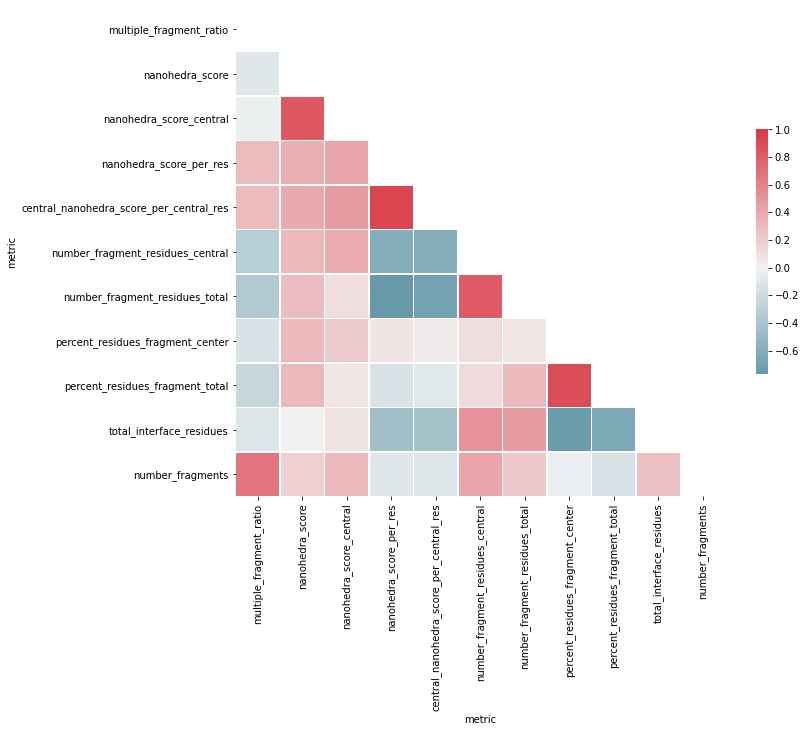

In [146]:
corr_df = subset_df[metrics_of_interest]
corr = corr_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Here you could plot pairs of correlated variables
add the pairs as a tuple in the metric pairs list

0.8419234180219471

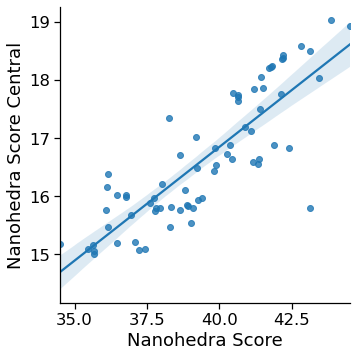

-0.05113645277407907

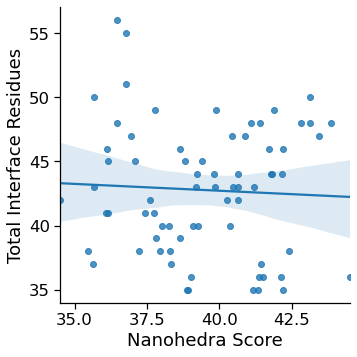

-0.44805897921781257

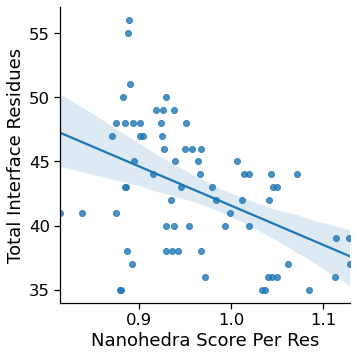

KeyError: 'protocol_energy_distance_sum'

In [100]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
# subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [('nanohedra_score', 'nanohedra_score_central'),
                ('nanohedra_score', 'total_interface_residues'),
                ('nanohedra_score_per_res', 'total_interface_residues'),
                 ]
# for x, y in combinations(metric_pairs):
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in metric_pairs:
        display(subset_df[x].corr(subset_df[y]))
        ax = sns.lmplot(x=x, y=y, data=subset_df)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        if x == 'protocol_energy_distance_sum':
            x = 'protocol_distance'
        ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
        plt.show()
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in bar_plot_pairs:
        display(subset_df[x].corr(subset_df[y]))
    #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#         ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        ax = sns.regplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        elif y == 'int_area_hydrophobic':
            y = 'hydrophobic_buried_surface_area'
        ax.set(xlabel='SSM elements', ylabel=' '.join(y.split('_')).title())  # format into a fancier axis title
        plt.show()
# sns.pairplot(subset_df, x_vars=['shape_complementarity', 'int_energy_res_summary_delta'], y_vars=['unique_fragments'],
#              height=5, aspect=.8, kind="reg")
# sns.pairplot(subset_df, y_vars=['shape_complementarity', 'int_energy_res_summary_delta'], x_vars=['unique_fragments'],
#             aspect=.8, kind="reg") # height=5
# sns.lmplot(x=y, y=x, data=subset_df, x_estimator=np.mean, col='vars', hue='vars')

0.5358091674094778

0.8198734978002182

-0.4348166451353058

-0.9396953085946905

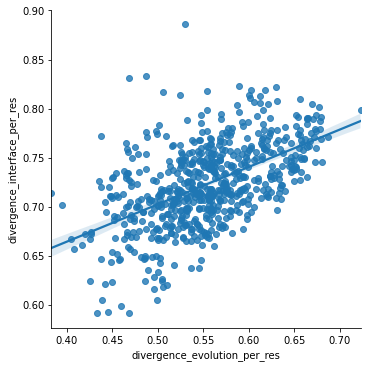

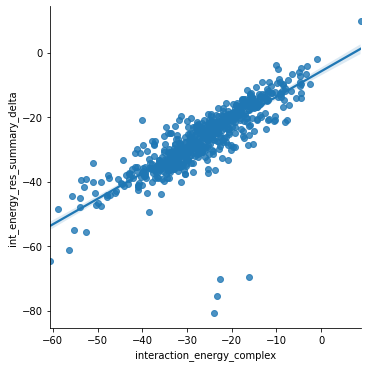

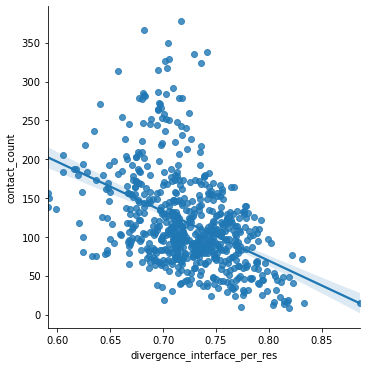

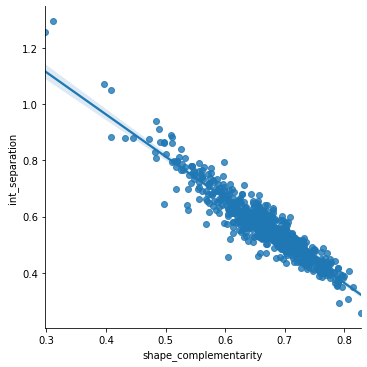

In [43]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [('divergence_evolution_per_res', 'divergence_interface_per_res'), 
                ('interaction_energy_complex', 'int_energy_res_summary_delta'),
                ('divergence_interface_per_res', 'contact_count'), 
                ('shape_complementarity', 'int_separation'), ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    sns.lmplot(x=x, y=y, data=subset_df)

In [44]:
metrics_of_interest = {'observed_evolution': '% Residues Obs. Evol.',
                       'int_area_total': 'Buried Surface Area (BSA)',
                       'shape_complementarity': 'Shape Complementarity',
                       'int_energy_res_summary_delta': 'Predicted Binding Energy', 
#                        'contact_count': 'Carbon-Carbon Contacts', 
                       'percent_int_area_hydrophobic': 'Hydrophobic BSA',
                       'number_hbonds': 'H-bonds',
                       'buns_total': 'Buried Unsat. H-bonds',
#                        'core', 'rim', 'support']  #'interaction_energy_complex', 'int_area_hydrophobic',
#                              'int_area_polar', 'int_area_total']
                      }

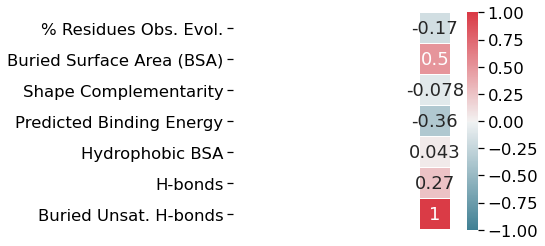

In [46]:
subset_df = protocol_df.droplevel(0, axis=1)
subset_df = subset_df['protocol_energy_distance_sum']
protocol_energy = {'protocol_energy_distance_sum': 'Protocol Distance'}
metrics_of_interest2 = metrics_of_interest.copy()
metrics_of_interest2.update(protocol_energy)
constraint_corr_df = pd.merge(no_constraint_protocol_df.droplevel(0, axis=1), subset_df, left_index=True, right_index=True)
subset_constraint_corr_df = constraint_corr_df[list(metrics_of_interest.keys())]  # + list(protocol_energy.keys())
subset_constraint_corr_df = subset_constraint_corr_df.rename(columns=metrics_of_interest)
corr = subset_constraint_corr_df.corr(method='spearman')
# mask = np.ones_like((len(corr), len(corr) - 1), dtype=np.bool)

# Generate a mask to display only correlations of interest
mask = np.ones_like(corr, dtype=np.bool)
# display(mask)
for i, row in enumerate(mask):
    mask[i][-1] = False
# display(mask)
# display(mask[: ,-1])
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Plot
with sns.plotting_context("notebook", font_scale=1.5):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, # cbar_kws={"shrink": .5},
                annot=True, xticklabels=False)

-0.04896870293552273

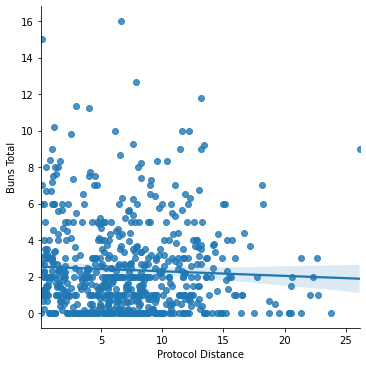

0.029807015989423515

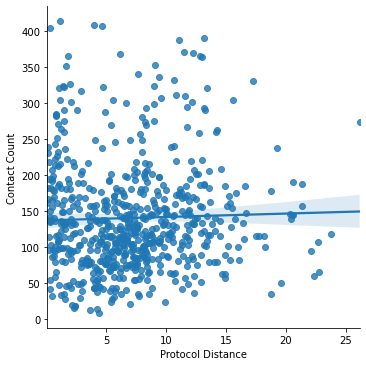

0.1093822884764262

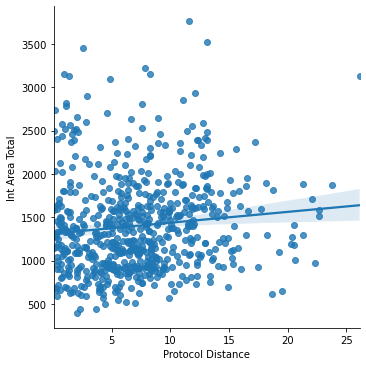

-0.11056487163124432

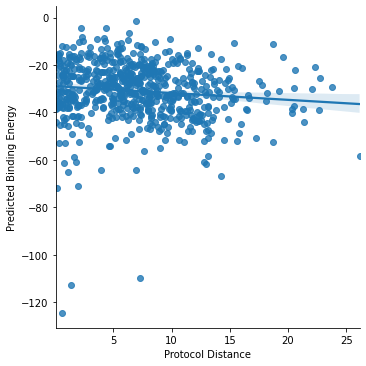

-0.10115573712066464

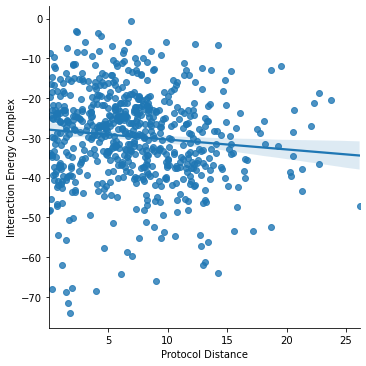

0.0767432887230824

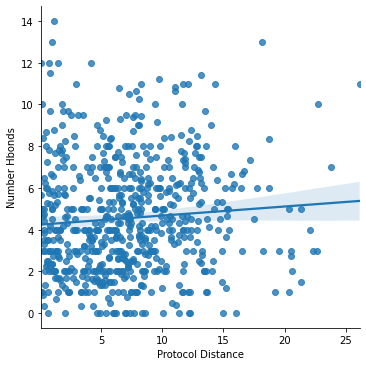

0.05537641329509701

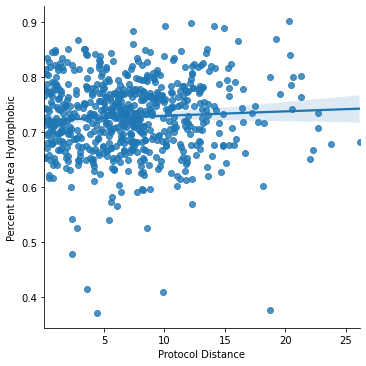

0.06912498379015046

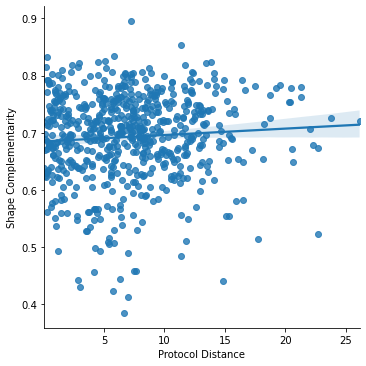

0.06575461634767506

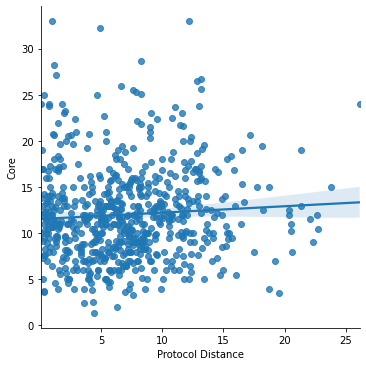

-0.009475537181021105

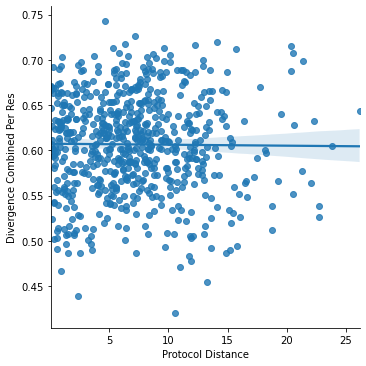

-0.023026973333753604

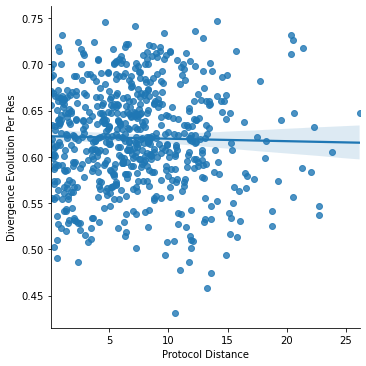

-0.03461434833483293

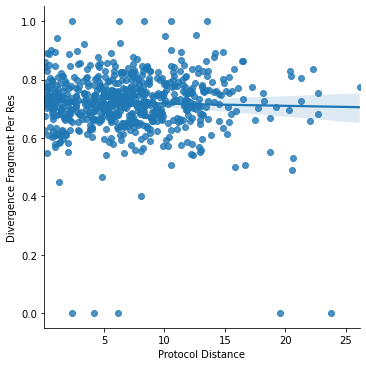

0.13714494644246372

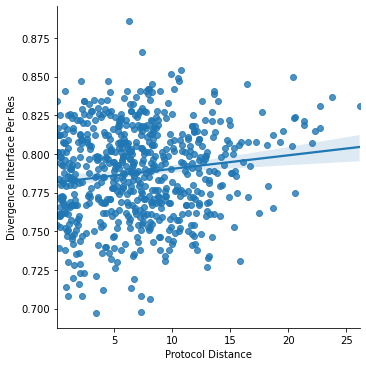

-0.06785635968687807

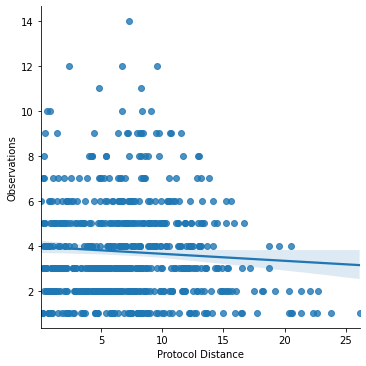

-0.06390743279626111

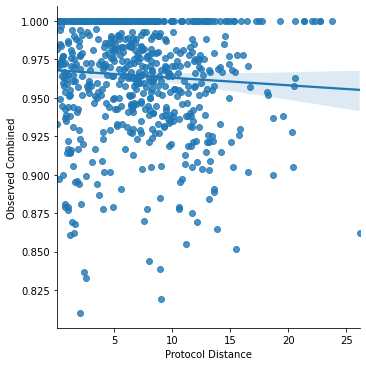

-0.1111422783025701

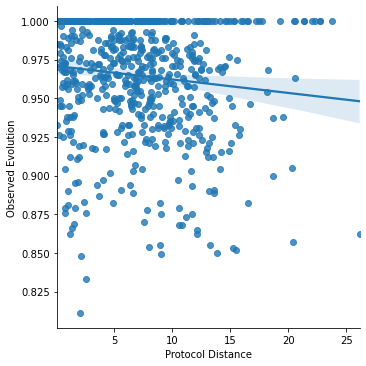

0.03497266934384523

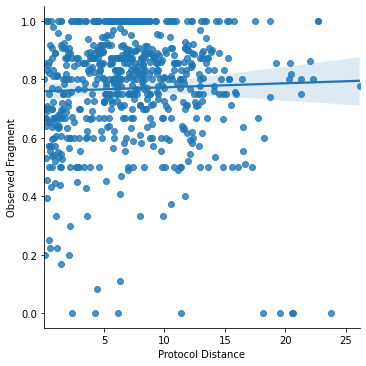

0.052375776552585296

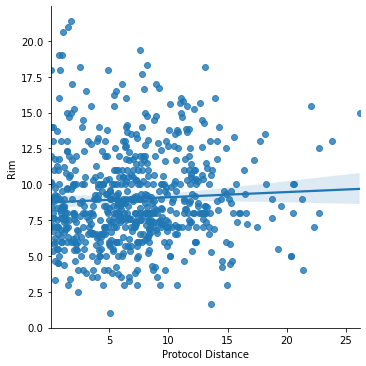

-0.01910454984823349

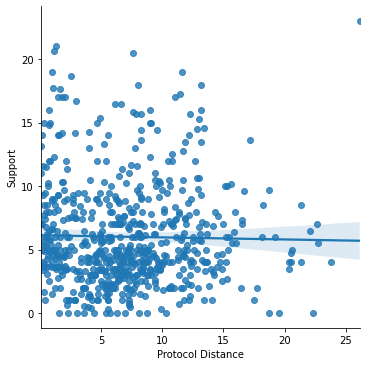

1.0

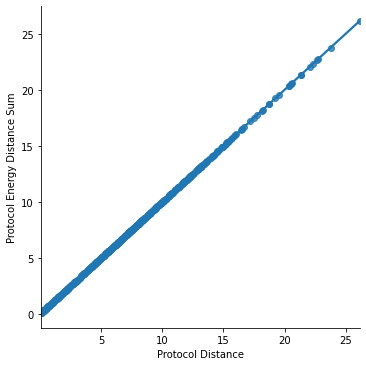

In [47]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
# subset_df = protocol_df.droplevel(0, axis=1)
# metric_pairs = [
# #                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
# #                 ('interaction_energy_complex', 'int_energy_res_summary_delta'),
# #                 ('divergence_interface_per_res', 'contact_count'), 
# #                 ('shape_complementarity', 'int_separation'),
# #                 ('percent_support', 'int_composition_diff'),
# #                 ('percent_rim', 'int_composition_diff'),
# #                 ('percent_core', 'int_composition_diff'),
# #                 ('int_composition_diff', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_composition_diff'),
#                 ('observed_evolution', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_energy_res_summary_delta'),
#                 ('unique_fragments', 'int_composition_diff')
# #                 ('observed_evolution', 'protocol_energy_distance_sum'),
# #                 ('observed_evolution', 'protocol_seq_distance_sum'),
# #                 ('percent_fragment', 'int_area_hydrophobic'),
#                 ]
subset_df = constraint_corr_df
from itertools import repeat
metric_pairs = zip(repeat('protocol_energy_distance_sum'), constraint_corr_df.columns.to_list())
# bar_plot_pairs = [
#                   ('unique_fragments', 'int_area_hydrophobic'),
#                   ('unique_fragments', 'shape_complementarity'),
#                   ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
#                  ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    ax = sns.lmplot(x=x, y=y, data=subset_df)
    if y == 'int_energy_res_summary_delta':
        y = 'predicted_binding_energy'
    if x == 'protocol_energy_distance_sum':
        x = 'protocol_distance'
    ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
    plt.show()
# for x, y in bar_plot_pairs:
#     display(subset_df[x].corr(subset_df[y]))
# #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#     ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
#     if y == 'int_energy_res_summary_delta':
#         y = 'predicted_binding_energy'
#     elif y == 'int_area_hydrophobic':
#         y = 'hydrophobic_buried_surface_area'
#     ax.set(xlabel='SSC elements', ylabel=' '.join(y.split('_')).title())
#     plt.show()

In [48]:
protocols_of_interest_freeVnot = {'no_constraint': 'Free', 'combo_profile': 'Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest_all = {'no_constraint': 'Free', 'combo_profile': 'Constraint', 'limit_to_profile': 'Latent Evolution', 'favor_profile': 'Weighted Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest = protocols_of_interest_freeVnot

## Reformat the data to pull specific columns and make a vertically stacked dataframe to produce Bar graphs which have a normalized z-value and are thus comparable across different scalar ranges

In [49]:
# from sklearn.preprocessing import StandardScaler

# normalized_df = design_protocols_df.subtract(design_protocols_df.min())

# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(design_protocols_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
# display(bar_df)
# display(bar_df.loc[:, ['Protocol']].isin(protocols_of_interest)['Protocol'])
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Protocol']].isin(protocols_of_interest.keys())['Protocol']]
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Metric']].isin(metrics_of_interest.keys())['Metric']]
# bar_df = bar_df[bar_df.loc[:, ['Protocol']] == protocols_of_interest]
display(bar_df)

Value  \
                                    metric                       protocol                     
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile     2.642857   
                                                                 no_constraint     6.400000   
                                    int_area_total               combo_profile  1645.445243   
                                                                 no_constraint  1795.745410   
                                    int_energy_res_summary_delta combo_profile   -36.732404   
...                                                                                     ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint     1.000000   
                                    percent_int_area_hydrophobic combo_profile     0.614864   
                                                                 no_constraint     0.541758   
                                    shape_complementarity        combo_profile     0.639006   
                                                                 no_constraint     0.649500   

                                                                                                      Metric  \
                                    metric                       protocol                                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile                    buns_total   
                                                                 no_constraint                    buns_total   
                                    int_area_total               combo_profile                int_area_total   
                                                                 no_constraint                int_area_total   
                                    int_energy_res_summary_delta combo_profile  int_energy_res_summary_delta   
...                                                                                                      ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint            observed_evolution   
                                    percent_int_area_hydrophobic combo_profile  percent_int_area_hydrophobic   
                                                                 no_constraint  percent_int_area_hydrophobic   
                                    shape_complementarity        combo_profile         shape_complementarity   
                                                                 no_constraint         shape_complementarity   

                                                                                     Protocol  
                                    metric                       protocol                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_area_total               combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_energy_res_summary_delta combo_profile  combo_profile  
...                                                                                       ...  
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  no_constraint  
                                    percent_int_area_hydrophobic combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    shape_complementarity        combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  

[9086 rows x 3 columns]

In [50]:
# First, normalize the data according to protocol groups
# display(bar_df.groupby('Metric').mean())
display(bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std()))
normalize_df = bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std())

# display(bar_df.groupby('Metric').min())
bar_s = bar_df.groupby('Metric').mean().squeeze()
# bar_s['int_energy_res_summary_delta'] = bar_s['int_energy_res_summary_delta'] * -1
# inverted_energy_df = bar_df
# inverted_energy_df['Value'] = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == 'int_energy_res_summary_delta', :], 'Value'] * -1
# display(inverted_energy_df)
mean_bar_s = bar_s
final_bar_df = bar_df
# display(mean_bar_s)
# bar_df[bar_df.loc[:, ['Metric']].isin(mean_bar_df)['Protocol']]
new_bar_l = []
for metric, metric_mean in zip(mean_bar_s.index, mean_bar_s):
#     print(metric_mean)
#     print(metric)
#     display(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], :])
#     print(bar_df[bar_df.loc[:, ['Metric']] == metric])
#     display(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
    if metric == 'int_energy_res_summary_delta':
        temp_df = pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean)
        new_bar_l.append(1 - (temp_df - 1))
    else:
        new_bar_l.append(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
new_bar_df = pd.concat(new_bar_l)
# display(new_bar_df)
#     new_bar_df = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean
    
#     bar_df = bar_df[bar_df.loc[:, ['Metric']] == metric] * metric_mean
# display(bar_df.loc[idx[:, :, :], ['Value']])
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# display(scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']]))
# final_bar_df['Value'] = scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']])

final_bar_df['Z-score'] = normalize_df.loc[idx[:, :, :], ['Value']]
# final_bar_df['Value'] = new_bar_df.loc[idx[:, :, :], ['Value']]
final_bar_df.rename(index=metrics_of_interest)

Value
                                    metric                       protocol               
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  0.158410
                                                                 no_constraint  1.804591
                                    int_area_total               combo_profile  0.505287
                                                                 no_constraint  0.789358
                                    int_energy_res_summary_delta combo_profile -0.729248
...                                                                                  ...
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  0.812255
                                    percent_int_area_hydrophobic combo_profile -1.458889
                                                                 no_constraint -2.536411
                                    shape_complementarity        combo_profile -0.504788
                                                                 no_constraint -0.370576

[9086 rows x 1 columns]

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

In [93]:
def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)

In [94]:
map_level(final_bar_df, metrics_of_interest, level=1)
map_level(final_bar_df, protocols_of_interest, level=2)

final_bar_df['Metric'] = final_bar_df.index.get_level_values(1)
final_bar_df['Protocol'] = final_bar_df.index.get_level_values(2)
                 
display(final_bar_df)

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

## Original view of all protocols
I started with int_energy_context_delta, shape_complementarity, buns_total, contact_count', 'interaction_energy_complex', int_area_hydrophobic, int_area_polar, int_area_total, number_hbonds

After analysis, it seems that some are not useful or the axis need to be moved to visualize. I am also trying different data shapes

I have finally reworked this so that the values are comparable. Scaling by mean and SD of each allows comparisons to be made. I specifically looked at combo_profile (Constrained, Constraint) versus no_constraint (Unconstrained, Free) protocols

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

<AxesSubplot:xlabel='Value', ylabel='Density'>

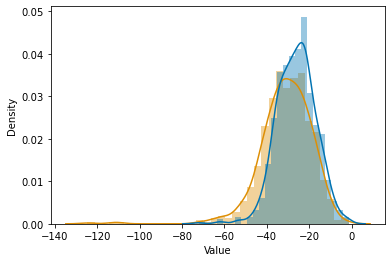

In [52]:
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Free'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[1])
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[0])
# sns.plot.show()

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


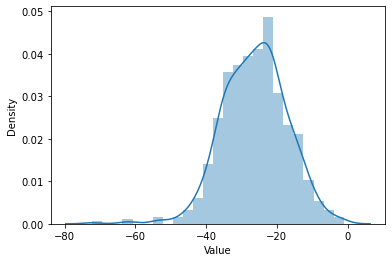

In [53]:
ax = sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


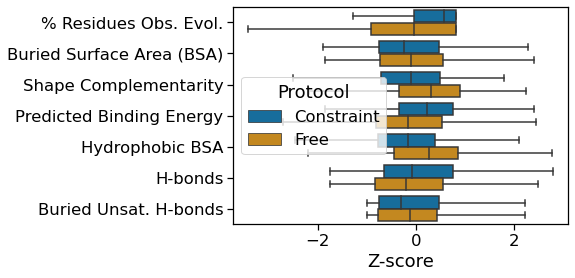

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


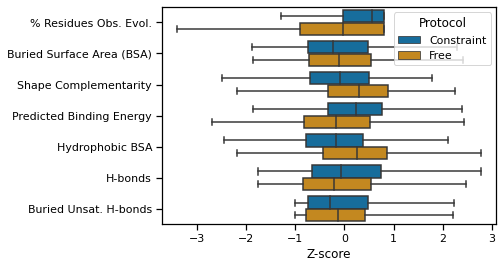

In [54]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

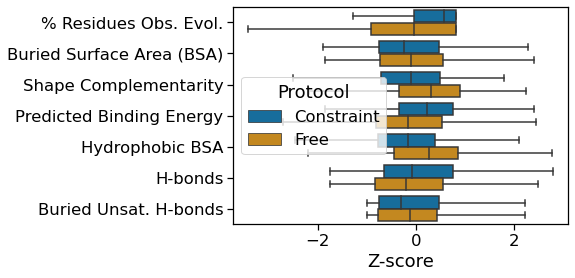

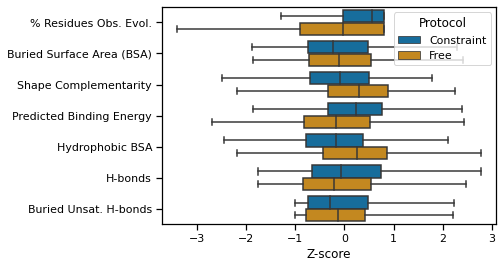

In [55]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

In [ ]:
protocol_specific_columns = ['int_energy_res_summary_delta', 'shape_complementarity',
                             'buns_total', 'contact_count', 'number_hbonds']
for metric in protocol_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['Metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="Protocol", y='Value', kind='box', data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

In [ ]:
bsa_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'int_area_hydrophobic'], bar_df[bar_df['Metric'] == 'int_area_polar'], bar_df[bar_df['Metric'] == 'int_area_total']])
# bar_df[bar_df['metric'] == 'int_area_hydrophobic']
# bar_df[bar_df['metric'] == 'int_area_polar']
# bar_df[bar_df['metric'] == 'int_area_total']
# display(bsa_bar_df)

In [ ]:
# with SD
# plt.figure(figsize=(100, 6))
# sns.barplot(x="metric", hue="protocol", y='Value', ci='sd', data=bsa_bar_df)
sns.catplot(x='Metric', y='Value', hue='Protocol', kind='violin', aspect=2, data=bsa_bar_df)  # hue="protocol", ci='sd'
plt.show()

# with 95% confidence interval
plt.figure(figsize=(20, 6))
sns.barplot(x='Metric', hue='Protocol', y='Value', data=bsa_bar_df)
plt.show()

In [ ]:
# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(seq_stats_protocol_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
display(bar_df)

In [ ]:
divergence_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'divergence_interface_per_res'], bar_df[bar_df['Metric'] == 'divergence_evolution_per_res']])
box = sns.catplot(x="Metric", y='Value', hue="Protocol", kind='box', aspect=2, data=divergence_bar_df)  #  ci='sd'
# ax = sns.boxplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'
# ax = sns.swarmplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'

In [ ]:
seq_specific_columns = ['divergence_interface_per_res', 'divergence_evolution_per_res']
# display(bar_df)
combo_favor_combined_df = pd.concat([bar_df[bar_df['protocol'] == 'combo_profile'], bar_df[bar_df['protocol'] == 'favor_profile']])
combo_favor_combined_df['protocol'] = 'combination'
bar_df = pd.concat([bar_df, combo_favor_combined_df])
for metric in seq_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="protocol", y='Value', kind='box', aspect=2, data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

## Need to add a couple of metrics to the Dataframe. All subsets are missing these...

In [ ]:
only_metrics_protocol_df = xtal_pose_df.droplevel(0, axis=1)
# only_metrics_protocol_df = columns_to_new_column(only_metrics_protocol_df, division_pairs, mode='truediv')
# display(only_metrics_protocol_df)
# only_metrics_protocol_df['percent_int_area_polar']

## Filtering by additional design filters which lead to good poses

I am going to remove designs not satisfying a couple of criteria that have been useful in past design work. This includes:

buried unsatisfied hydrogen bonds (Stranges and Khulman 2013): 2/1000A

percent polar interface area (): >30%

NOT YET number of h bonds: <10 <8?

In [ ]:
design_requirements = {'percent_int_area_polar': 0.4, 'buns_per_ang': 0.002}  #, 'number_hbonds': 10}
design_requirements.update(crystal_means)

In [ ]:
crystal_filters = {column: {'direction': filter_key_df.loc['direction', column], 'value': design_requirements[column]} 
                   for column in design_requirements}

print('Starting designs = %d' % len(only_metrics_protocol_df))
print('Using filter parameters: %s' % str(crystal_filters))
crystal_filters_with_idx = df_filter_index_by_value(only_metrics_protocol_df, **crystal_filters)
# Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
# on whether the column should be sorted max/min
# Args:
#     df (pandas.DataFrame): DataFrame to filter indices on
# Keyword Args:
#     kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
for _filter in crystal_filters_with_idx:
    print('%s designs = %d' % (_filter, len(crystal_filters_with_idx[_filter]['idx'])))

In [ ]:
# print(crystal_filters_with_idx)
design_indices = {_filter: crystal_filters_with_idx[_filter]['idx'] for _filter in crystal_filters_with_idx}
# display(design_indices[0])
symmetry_and_design_filtered_idx = index_intersection(design_indices)
print('Final number of designs passing all metrics is %d' % len(symmetry_and_design_filtered_idx))
symmetry_and_design_filtered_df = only_metrics_protocol_df.loc[symmetry_and_design_filtered_idx, :]

In [217]:
metrics = {'average_fragment_z_score': 'The average fragment z-value used in docking/design',
                 'buns_heavy_total': 'Buried unsaturated H-bonding heavy atoms in the design',
                 'buns_hpol_total': 'Buried unsaturated H-bonding polarized hydrogen atoms in the design',
                 'buns_total': 'Total buried unsaturated H-bonds in the design',
                 'buns_per_ang': 'Buried Unsaturated Hbonds per Angstrom^2 of interface',
                 'component_1_symmetry': 'The symmetry group of component 1',
                 'component_1_name': 'component 1 PDB_ID',
                 'component_1_number_of_residues': 'The number of residues in the monomer of component 1',
                 'component_1_max_radius': 'The maximum distance that component 1 reaches away from the center of mass',
                 'component_1_n_terminal_helix': 'Whether the n-terminus has an alpha helix',
                 'component_1_c_terminal_helix': 'Whether the c-terminus has an alpha helix',
                 'component_1_n_terminal_orientation':
                     'The direction the n-terminus is oriented from the symmetry group center of mass. 1 is away, -1 is'
                     ' towards',
                 'component_1_c_terminal_orientation':
                     'The direction the c-terminus is oriented from the symmetry group center of mass. 1 is away, -1 is'
                     ' towards',
                 'component_2_symmetry': 'The symmetry group of component 2',
                 'component_2_name': 'component 2 PDB_ID',
                 'component_2_number_of_residues': 'The number of residues in the monomer of component 2',
                 'component_2_max_radius': 'The maximum distance that component 2 reaches away from the center of mass',
                 'component_2_n_terminal_helix': 'Whether the n-terminus has an alpha helix',
                 'component_2_c_terminal_helix': 'Whether the c-terminus has an alpha helix',
                 'component_2_n_terminal_orientation':
                     'The direction the n-terminus is oriented from the symmetry group center of mass. 1 is away, -1 is'
                     ' towards',
                 'component_2_c_terminal_orientation':
                     'The direction the c-terminus is oriented from the symmetry group center of mass. 1 is away, -1 is'
                     ' towards',
                 'contact_count': 'Number of carbon-carbon contacts across interface',
                 'core': 'The number of \'core\' residues as classified by E. Levy 2010',
                 'cst_weight': 'Total weight of coordinate constraints to keep design from moving in cartesian space',
                 'divergence_combined_per_residue': 'The Jensen-Shannon divergence of interface residues from the'
                                                    ' position specific design profile values. Includes fragment & '
                                                    'evolution if both are True, otherwise only includes those '
                                                    'specified for use in design.',
                 'divergence_fragment_per_residue': 'The Jensen-Shannon divergence of interface residues from the'
                                                    ' position specific fragment profile',
                 'divergence_evolution_per_residue': 'The Jensen-Shannon divergence of interface residues from the'
                                                     ' position specific evolutionary profile',
                 'divergence_interface_per_residue': 'The Jensen-Shannon divergence of interface residues from the'
                                                     ' typical interface background',
                 'fsp_energy': 'Total weight of sequence constraints used to favor certain amino acids in design. '
                               'Only protocols with a favored profile have values',
                 'int_area_hydrophobic': 'Total hydrophobic interface buried surface area',
                 'int_area_polar': 'Total polar interface buried surface area',
                 'int_area_res_summary_hydrophobic_1_unbound': 
                     'Sum of each interface residue\'s hydrophobic area for interface1',
                 'int_area_res_summary_hydrophobic_2_unbound': 
                     'Sum of each interface residue\'s hydrophobic area for interface2',
                 'int_area_res_summary_polar_1_unbound': 'Sum of each interface residue\'s polar area for interface1',
                 'int_area_res_summary_polar_2_unbound': 'Sum of each interface residue\'s polar area for interface2',
                 'int_area_res_summary_total_1_unbound': 'Sum of each interface residue\'s total area for interface1',
                 'int_area_res_summary_total_2_unbound': 'Sum of each interface residue\'s total area for interface2',
                 'int_area_total': 'Total interface buried surface area',
                 'int_composition_similarity':
                     'The similarity to the expected interface composition given interface buried surface area. '
                     '1 is similar to natural interfaces, 0 is dissimilar',
                 'int_connectivity_1': 'How embedded is interface1 in the rest of the protein?',
                 'int_connectivity_2': 'How embedded is interface2 in the rest of the protein?',
                 'int_energy_res_summary_complex': 'Total interface residue energies in the complexed state',
                 'int_energy_res_summary_delta': 'deltaG of int_energy_res_summary_complex and _unbound',
                 'int_energy_res_summary_unbound': 'Total interface residue energies in the unbound state',
                 'int_energy_res_summary_1_unbound': 'Sum of interface1 residue energies in the unbound state',
                 'int_energy_res_summary_2_unbound': 'Sum of interface2 residue energies in the unbound state',
                 'int_separation': 'Median distance between all atom points on each side of the interface',
                 'interaction_energy_complex': 'The two-body (residue-pair) energy of the complexed interface. '
                                               'No solvation energies',
                 'interface_b_factor_per_res': 'The average B-factor from each atom, from each interface residue',
                 'multiple_fragment_ratio': 'The extent to which fragment observations are connected in the interface.'
                                            ' Higher ratio means multiple fragment observations per residue',
                 'number_hbonds': 'The number of residues making H-bonds in the total interface. Residues may make more'
                                  ' than one H-bond',
                 'nanohedra_score': 'Sum of total fragment containing residue match scores (1 / 1 + Z-score^2) weighted'
                                    ' by their ranked match score. Maximum of 2/residue',
                 'nanohedra_score_center': 'nanohedra_score for the central fragment residues only',
                 'nanohedra_score_per_res': 'The Nanohedra Score normalized by number of fragment residues',
                 'nanohedra_score_center_per_res_center':
                     'The central Nanohedra Score normalized by number of central fragment residues',
                 'number_fragment_residues_total': 'The number of residues in the interface with fragment observations'
                                                   'found',
                 'number_fragment_residues_center': 'The number of residues in the interface that are the central '
                                                     'fragment observation',
                 'observations': 'Number of unique design trajectories contributing to statistics',
                 'observed_design': 'Percent of observed residues in combined profile. 1 is 100%',
                 'observed_evolution': 'Percent of observed residues in evolutionary profile. 1 is 100%',
                 'observed_interface': 'Percent of observed residues in fragment profile. 1 is 100%',
                 'percent_core': 'The percentage of total residues which are \'core\' according to Levy, E. 2010',
                 'percent_fragment': 'Percent of residues with fragment data out of total residues',
                 'percent_fragment_coil': 'The percentage of fragments represented from coiled SS elements',
                 'percent_fragment_helix': 'The percentage of fragments represented from an a-helix SS elements',
                 'percent_fragment_strand': 'The percentage of fragments represented from a b-strand SS elements',
                 'percent_int_area_hydrophobic': 'The percent of interface area which is occupied by hydrophobic atoms',
                 'percent_int_area_polar': 'The percent of interface area which is occupied by polar atoms',
                 'percent_rim': 'The percentage of total residues which are \'rim\' according to Levy, E. 2010',
                 'percent_support': 'The percentage of total residues which are \'support\' according to Levy, E. 2010',
                 'protocol_energy_distance_sum':
                     'The distance between the average linearly embedded per residue energy co-variation between '
                     'specified protocols. Larger = greater distance. A small distance indicates that different '
                     'protocols arrived at the same per residue energy conclusions despite different pools of amino '
                     'acids specified for sampling',
                 'protocol_similarity_sum':
                     'The statistical similarity between all sampled protocols. Larger is more similar, indicating that'
                     ' different protocols have interface statistics that are similar despite different pools of amino '
                     'acids specified for sampling',
                 'protocol_seq_distance_sum':
                     'The distance between the average linearly embedded sequence differences between specified '
                     'protocols. Larger = greater distance. A small distance indicates that different '
                     'protocols arrived at the same per residue energy conclusions despite different pools of amino '
                     'acids specified for sampling',
                 'ref': 'Rosetta Energy Term - A metric for the unfolded energy of the protein along with sequence '
                        'fitting corrections',
                 'rim': 'The number of \'rim\' residues as classified by E. Levy 2010',
                 'rmsd': 'Root Mean Square Deviation of all CA atoms between the refined (relaxed) and designed states',
                 'protocol': 'Protocols utilized to search sequence space given fragment and/or evolutionary constraint '
                         'information',
                 'shape_complementarity': 'Interface shape complementarity (SC). Measure of fit between two surfaces',
                 'solvation_energy': 'Energy required to hydrate the unbound components',
                 'support': 'The number of \'support\' residues as classified by E. Levy 2010',
                 'symmetry': 'The specific symmetry type used design (point (0), layer (2), lattice(3))',
                 'fragment_z_score_total': 'The sum of all fragments z-values',
                 'number_of_fragments': 'The number of fragments found in the pose interface',
                 'total_interface_residues':
                     'The total number of interface residues found in the pose (residue CB within 8A)',
                 'REU': 'Rosetta Energy Units. Always 0. We can disregard',
                 'coordinate_constraint': 'Same as cst_weight',
                 'res_type_constraint': 'Same as fsp_energy',
                 'time': 'Time for the protocol to complete',
                 'hbonds_res_selection_unbound': 'The specific h-bonds present in the bound pose',
                 'hbonds_res_selection_1_unbound': 'The specific h-bonds present in the unbound interface1',
                 'hbonds_res_selection_2_unbound': 'The specific h-bonds present in the unbound interface2',
                 'dslf_fa13': 'Rosetta Energy Term - disulfide bonding',
                 'fa_atr': 'Rosetta Energy Term - lennard jones full atom atractive forces',
                 'fa_dun': 'Rosetta Energy Term - dunbrack rotamer library statistical probability',
                 'fa_elec': 'Rosetta Energy Term - full atom electrostatic forces',
                 'fa_intra_rep': 'Rosetta Energy Term - lennard jones full atom intra-residue repulsive forces',
                 'fa_intra_sol_xover4': 'Rosetta Energy Term - full atom intra-residue solvent forces',
                 'fa_rep': 'Rosetta Energy Term - lennard jones full atom repulsive forces',
                 'fa_sol': 'Rosetta Energy Term - full atom solvent forces',
                 'hbond_bb_sc': 'Rosetta Energy Term - backbone/sidechain hydrogen bonding',
                 'hbond_lr_bb': 'Rosetta Energy Term - long range backbone hydrogen bonding',
                 'hbond_sc': 'Rosetta Energy Term - side-chain hydrogen bonding',
                 'hbond_sr_bb': 'Rosetta Energy Term - short range backbone hydrogen bonding',
                 'lk_ball_wtd': 'Rosetta Energy Term - Lazaris-Karplus weighted anisotropic solvation energy?',
                 'omega': 'Rosetta Energy Term - Lazaris-Karplus weighted anisotropic solvation energy?',
                 'p_aa_pp': '"Rosetta Energy Term - statistical probability of an amino acid given angles phi',
                 'pro_close': 'Rosetta Energy Term - to favor closing of proline rings',
                 'rama_prepro': 'Rosetta Energy Term - amino acid dependent term to favor certain ramachandran angles '
                                'on residue before prolines',
                 'yhh_planarity': 'Rosetta Energy Term - to favor planarity of tyrosine hydrogen'}

In [222]:
new_metrics = {}
for key, value in metrics.items():
    try:
        new_metrics[key] = {'description': value, 
                            'direction': filter_key_df.loc['direction', key], 
                            'function': filter_key_df.loc['function', key], 
                            'filter': bool(filter_key_df.loc['filter', key])}
    except KeyError:
        new_metrics[key] = {'description': value, 'direction': None,
                            'function': None, 'filter': None}
        print(key)

component_1_name
component_1_max_radius
component_1_n_terminal_helix
component_1_c_terminal_helix
component_1_n_terminal_orientation
component_1_c_terminal_orientation
component_2_name
component_2_max_radius
component_2_n_terminal_helix
component_2_c_terminal_helix
component_2_n_terminal_orientation
component_2_c_terminal_orientation
divergence_combined_per_residue
divergence_fragment_per_residue
divergence_evolution_per_residue
divergence_interface_per_residue
int_energy_res_summary_2_unbound
nanohedra_score_center
nanohedra_score_center_per_res_center
number_fragment_residues_center
observed_interface
protocol
symmetry
fragment_z_score_total
number_of_fragments
REU
coordinate_constraint
res_type_constraint
time
hbonds_res_selection_unbound
hbonds_res_selection_1_unbound
hbonds_res_selection_2_unbound
dslf_fa13
fa_atr
fa_dun
fa_elec
fa_intra_rep
fa_intra_sol_xover4
fa_rep
fa_sol
hbond_bb_sc
hbond_lr_bb
hbond_sc
hbond_sr_bb
lk_ball_wtd
omega
p_aa_pp
pro_close
rama_prepro
yhh_planarity


In [224]:
pd.DataFrame(new_metrics)

,average_fragment_z_score,buns_heavy_total,buns_hpol_total,buns_total,buns_per_ang,component_1_symmetry,component_1_name,component_1_number_of_residues,component_1_max_radius,component_1_n_terminal_helix,component_1_c_terminal_helix,component_1_n_terminal_orientation,component_1_c_terminal_orientation,component_2_symmetry,component_2_name,component_2_number_of_residues,component_2_max_radius,component_2_n_terminal_helix,component_2_c_terminal_helix,component_2_n_terminal_orientation,component_2_c_terminal_orientation,contact_count,core,cst_weight,divergence_combined_per_residue,divergence_fragment_per_residue,divergence_evolution_per_residue,divergence_interface_per_residue,fsp_energy,int_area_hydrophobic,int_area_polar,int_area_res_summary_hydrophobic_1_unbound,int_area_res_summary_hydrophobic_2_unbound,int_area_res_summary_polar_1_unbound,int_area_res_summary_polar_2_unbound,int_area_res_summary_total_1_unbound,int_area_res_summary_total_2_unbound,int_area_total,int_composition_similarity,int_connectivity_1,int_connectivity_2,int_energy_res_summary_complex,int_energy_res_summary_delta,int_energy_res_summary_unbound,int_energy_res_summary_1_unbound,int_energy_res_summary_2_unbound,int_separation,interaction_energy_complex,interface_b_factor_per_res,multiple_fragment_ratio,number_hbonds,nanohedra_score,nanohedra_score_center,nanohedra_score_per_res,nanohedra_score_center_per_res_center,number_fragment_residues_total,number_fragment_residues_center,observations,observed_design,observed_evolution,observed_interface,percent_core,percent_fragment,percent_fragment_coil,percent_fragment_helix,percent_fragment_strand,percent_int_area_hydrophobic,percent_int_area_polar,percent_rim,percent_support,protocol_energy_distance_sum,protocol_similarity_sum,protocol_seq_distance_sum,ref,rim,rmsd,protocol,shape_complementarity,solvation_energy,support,symmetry,fragment_z_score_total,number_of_fragments,total_interface_residues,REU,coordinate_constraint,res_type_constraint,time,hbonds_res_selection_unbound,hbonds_res_selection_1_unbound,hbonds_res_selection_2_unbound,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,yhh_planarity
description,The average fragment z-value used in docking/d...,Buried unsaturated H-bonding heavy atoms in th...,Buried unsaturated H-bonding polarized hydroge...,Total buried unsaturated H-bonds in the design,Buried Unsaturated Hbonds per Angstrom^2 of in...,The symmetry group of component 1,component 1 PDB_ID,The number of residues in the monomer of compo...,The maximum distance that component 1 reaches ...,Whether the n-terminus has an alpha helix,Whether the c-terminus has an alpha helix,The direction the n-terminus is oriented from ...,The direction the c-terminus is oriented from ...,The symmetry group of component 2,component 2 PDB_ID,The number of residues in the monomer of compo...,The maximum distance that component 2 reaches ...,Whether the n-terminus has an alpha helix,Whether the c-terminus has an alpha helix,The direction the n-terminus is oriented from ...,The direction the c-terminus is oriented from ...,Number of carbon-carbon contacts across interface,The number of 'core' residues as classified by...,Total weight of coordinate constraints to keep...,The Jensen-Shannon divergence of interface res...,The Jensen-Shannon divergence of interface res...,The Jensen-Shannon divergence of interface res...,The Jensen-Shannon divergence of interface res...,Total weight of sequence constraints used to f...,Total hydrophobic interface buried surface area,Total polar interface buried surface area,Sum of each interface residue's hydrophobic ar...,Sum of each interface residue's hydrophobic ar...,Sum of each interface residue's polar area for...,Sum of each interface residue's polar area for...,Sum of each interface residue's total area for...,Sum of each interface residue's total area for...,Total 